### Hyper Parameter Tuning

모델 평가와 하이어 파라미터 튜닝

- 편향되지 않은 모델 성능 추정하기
- 머신러닝 알고리즘에서 일반적으로 발생하는 문제 분석하기
- 머신러닝 모델 세부 튜닝하기
- 여러가지 성능지표를 사용하여 모델의 예측 성능 평가

**Sample Data Set**

- 악성과 양성인 종양 세포 샘플 569개
- 데이터 첫 두 열 : 샘플의 고유 ID, 진단 결과 (M = 악성, B = 양성)
- 3~32번째 열 : 세포핵의 디지털 이미지에서 계산된 30개의 실수 값 특성

데이터를 읽어온 후 LabelEncoder를 사용하여 클래스 레이블(진단결과)을 정수로 변환하고, train_test_split 함수를 이용해 전체 데이터셋을 훈련 세트와 테스트 세트로 나눈다

In [1]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)

In [2]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.20,
    stratify=y,
    random_state=1
)

#### Pipeline

사이킷런의 PipeLine 클래스를 사용하여 표준화(StandardScaler), 주성분 분석(PCA), 로지스틱 회귀(LogisticRegression) 객체를 연결한다

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(
    StandardScaler(),
    PCA(n_components = 2),
    LogisticRegression(solver = 'liblinear', random_state = 42)
)

In [6]:
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.956


#### Cross Validation

- Holdout Cross Validation
- K-Fold Cross Validation
- Stratified K-Fold Cross Validation : 각 폴드에서 클래스 비율이 전체 훈련 세트에 있는 class 비율을 대표하도록 유지한다

In [7]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
    

kfold = StratifiedKFold(n_splits = 10).split(X_train, y_train)

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %2d, Dist of classes: %s, Accuracy: %.3f' % (k+1,
          np.bincount(y_train[train]), score))
    
print('\nCross Validation Accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold:  1, Dist of classes: [256 153], Accuracy: 0.935
Fold:  2, Dist of classes: [256 153], Accuracy: 0.935
Fold:  3, Dist of classes: [256 153], Accuracy: 0.957
Fold:  4, Dist of classes: [256 153], Accuracy: 0.957
Fold:  5, Dist of classes: [256 153], Accuracy: 0.935
Fold:  6, Dist of classes: [257 153], Accuracy: 0.956
Fold:  7, Dist of classes: [257 153], Accuracy: 0.978
Fold:  8, Dist of classes: [257 153], Accuracy: 0.933
Fold:  9, Dist of classes: [257 153], Accuracy: 0.956
Fold: 10, Dist of classes: [257 153], Accuracy: 0.956

Cross Validation Accuracy: 0.950 +/- 0.014


In [8]:
from sklearn.model_selection import cross_validate

scores = cross_validate(estimator=pipe_lr, 
                        X=X_train, 
                        y=y_train, 
                        scoring=['accuracy'], 
                        cv=10, 
                        n_jobs=-1,
                        return_train_score=False)
print('CV accuracy score: %s' % scores['test_accuracy'])
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores['test_accuracy']), 
                                      np.std(scores['test_accuracy'])))

CV accuracy score: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV accuracy: 0.950 +/- 0.014


#### Learning Curve

In [9]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

pipe_lr = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        solver = 'liblinear', 
        penalty = 'l2', 
        random_state = 42
    )
)

train_sizes, train_scores, test_scores = learning_curve(
    estimator = pipe_lr,
    X = X_train,
    y = y_train,
    train_sizes = np.linspace(0.1, 1.0, 10),
    cv = 10,
    n_jobs = 1
)

train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis = 1) 

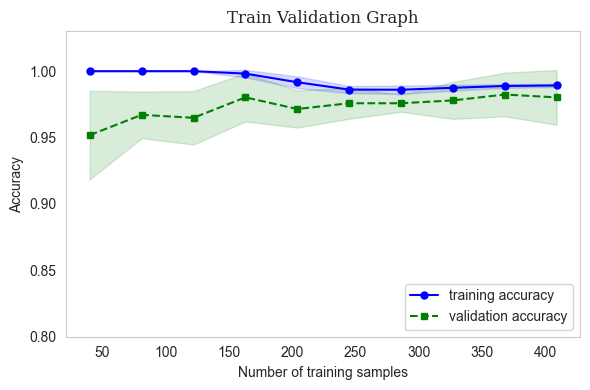

In [10]:
plt.figure(figsize = (6,4))

plt.plot(train_sizes, 
         train_mean,
         color = 'blue', 
         marker = 'o',
         markersize = 5, 
         label = 'training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha = 0.15, 
                 color = 'blue')

plt.plot(train_sizes, 
         test_mean,
         color = 'green', 
         linestyle = '--',
         marker = 's', 
         markersize = 5,
         label = 'validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha = 0.15, 
                 color = 'green')

plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.title('Train Validation Graph', fontsize = 12, fontfamily = 'Serif')
plt.legend(loc = 'lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.grid(False)
plt.show()

**검증 곡선을 이용한 Overfitting Underfitting 검증**

In [11]:
from sklearn.model_selection import validation_curve


param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
    estimator = pipe_lr, 
    X = X_train, 
    y = y_train, 
    param_name = 'logisticregression__C', 
    param_range = param_range,
    cv = 10
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

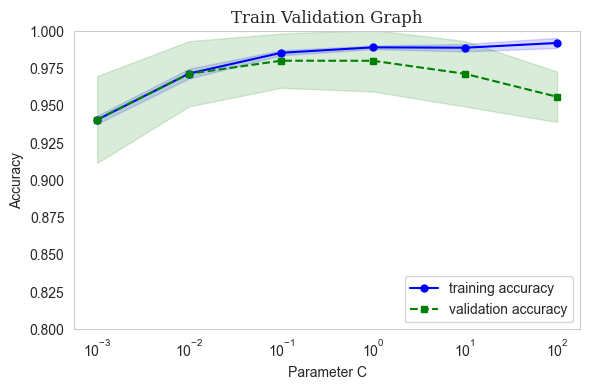

In [12]:
plt.figure(figsize = (6,4))
plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid(False)
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.title('Train Validation Graph', fontsize = 12, fontfamily = 'Serif')
plt.ylim([0.8, 1.00])
plt.tight_layout()
plt.show()

#### GridSearch Hyper Parameter Tuning

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(
    StandardScaler(),
    SVC(random_state = 42)
)

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [
    {'svc__C': param_range, 
     'svc__kernel': ['linear']},
    {'svc__C': param_range, 
     'svc__gamma': param_range, 
     'svc__kernel': ['rbf']}
]

gs = GridSearchCV(
    estimator = pipe_svc,
    param_grid = param_grid,
    scoring = 'accuracy',
    cv = 10,
    n_jobs = 1
)

gs = gs.fit(
    X_train,
    y_train
)

print(gs.best_score_)
print(gs.best_params_)

0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [14]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('test accuracy : %.3f' % clf.score(X_test, y_test))

test accuracy : 0.974


#### 중첩 교차 검증을 사용한 알고리즘 선택

In [16]:
from sklearn.model_selection import cross_val_score

gs = GridSearchCV(
    estimator = pipe_svc,
    param_grid = param_grid,
    scoring = 'accuracy',
    cv = 2)

scores = cross_val_score(
    gs, 
    X_train, 
    y_train, 
    scoring = 'accuracy', 
    cv = 5)
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Cross Validation accuracy: 0.974 +/- 0.015


In [17]:
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(
    estimator = DecisionTreeClassifier(random_state = 42),
    param_grid = [
        {
            'max_depth': [1, 2, 3, 4, 5, 6, 7, None]
        }
    ],
        scoring = 'accuracy',
        cv = 2)

scores = cross_val_score(
    gs, 
    X_train, 
    y_train, 
    scoring = 'accuracy', 
    cv = 5
)

print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Cross Validation accuracy: 0.932 +/- 0.022


#### Other Metrics

In [18]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confusion_matrices = confusion_matrix(y_true = y_test, y_pred = y_pred)

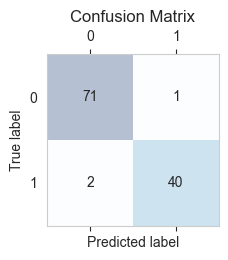

In [21]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confusion_matrices, cmap = plt.cm.Blues, alpha=0.3)
for i in range(confusion_matrices.shape[0]):
    for j in range(confusion_matrices.shape[1]):
        ax.text(x=j, y=i, s = confusion_matrices[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.grid(False)
plt.title('Confusion Matrix')
plt.show()

#### 분류 모델의 정밀도와 재현율 최적화

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision Score : %.3f' % precision_score(y_true = y_test, y_pred = y_pred))
print('Recall Score : %.3f' % recall_score(y_true = y_test, y_pred = y_pred))
print('F1 : %.3f' % f1_score(y_true = y_test, y_pred = y_pred))

Precision Score : 0.976
Recall Score : 0.952
F1 : 0.964


In [23]:
from sklearn.metrics import make_scorer

scorer = make_scorer(f1_score, pos_label=0)

c_gamma_range = [0.01, 0.1, 1.0, 10.0]

param_grid = [{'svc__C': c_gamma_range,
               'svc__kernel': ['linear']},
              {'svc__C': c_gamma_range,
               'svc__gamma': c_gamma_range,
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator = pipe_svc,
                  param_grid = param_grid,
                  scoring = scorer,
                  cv = 10,
                  n_jobs = -1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9861994953378878
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


#### ROC Curve

/var/folders/1q/pl9tj55n57s9jg28npxw61n80000gn/T/ipykernel_65962/3442208852.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)
/var/folders/1q/pl9tj55n57s9jg28npxw61n80000gn/T/ipykernel_65962/3442208852.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)
/var/folders/1q/pl9tj55n57s9jg28npxw61n80000gn/T/ipykernel_65962/3442208852.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)


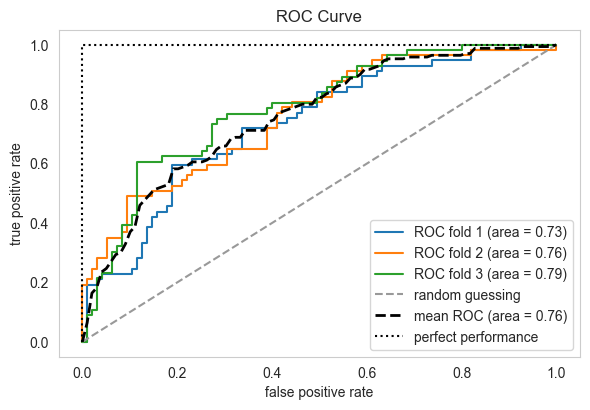

In [29]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components = 2),
                        LogisticRegression(solver = 'liblinear',
                                           penalty = 'l2', 
                                           random_state = 1, 
                                           C = 100.0))

X_train2 = X_train[:, [4, 14]]
    

cv = list(StratifiedKFold(n_splits = 3).split(X_train, y_train))

fig = plt.figure(figsize = (6, 4))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc="lower right")
plt.grid(False)
plt.tight_layout()
plt.title('ROC Curve')
plt.show()

#### 다중 분류의 성능 지표

In [30]:
pre_scorer = make_scorer(
    score_func = precision_score,
    pos_label = 1,
    greater_is_better = True,
    average = 'micro'
)

불균형 클래스 다루기

In [32]:
X_imb = np.vstack((X[y == 0], X[y == 1][:40]))
y_imb = np.hstack((y[y == 0], y[y == 1][:40]))

In [33]:
y_pred = np.zeros(y_imb.shape[0])
np.mean(y_pred == y_imb) * 100

89.92443324937027

In [34]:
from sklearn.utils import resample

print('샘플링하기 전의 클래스 1의 샘플 개수:', X_imb[y_imb == 1].shape[0])

X_upsampled, y_upsampled = resample(X_imb[y_imb == 1],
                                    y_imb[y_imb == 1],
                                    replace=True,
                                    n_samples=X_imb[y_imb == 0].shape[0],
                                    random_state=123)

print('샘플링한 후의 클래스 1의 샘플 개수:', X_upsampled.shape[0])

샘플링하기 전의 클래스 1의 샘플 개수: 40
샘플링한 후의 클래스 1의 샘플 개수: 357


In [35]:
X_bal = np.vstack((X[y == 0], X_upsampled))
y_bal = np.hstack((y[y == 0], y_upsampled))

In [36]:
y_pred = np.zeros(y_bal.shape[0])
np.mean(y_pred == y_bal) * 100

50.0